In [2]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_theme(color_codes=True)

from scipy.stats import pearsonr

# spectrome imports:
from spectrome.brain import Brain
from spectrome.utils import functions, path, generate
from spectrome.forward import eigenmode, laplacian

In [5]:
## Set-up, load, and house-keeping:
data_dir = "../data"

# Load Pablo's Yeo 2017 canonical network maps
# fc_dk = np.load("../data/com_dk.npy", allow_pickle=True).item()
fc_dk_normalized = pd.read_csv("../data/DK_dictionary_normalized.csv").set_index(
    "Unnamed: 0"
)

# define list of canonical network names and re-order the dictionary using these names:
fc_names = [
    "Limbic",
    "Default",
    "Visual",
    "Fronto \n parietal",
    "Somato \n motor",
    "Dorsal \n Attention",
    "Ventral \n Attention",
]

fc_dk_normalized = fc_dk_normalized.reindex(
    [
        "Limbic",
        "Default",
        "Visual",
        "Frontoparietal",
        "Somatomotor",
        "Dorsal_Attention",
        "Ventral_Attention",
    ]
).fillna(0)

opt_param = np.zeros([len(fc_names), 2])

## Load the optimized parameters first
h5_path = os.path.join(data_dir, "default.h5")
bh_default = path.read_hdf5(h5_path)
opt_param[1, :] = bh_default["x"]
# print('Default network parameters:' + str(np.round(bh_default['x'],2)))

h5_path = os.path.join(data_dir, "dorsal.h5")
bh_dorsal = path.read_hdf5(h5_path)
opt_param[5, :] = bh_dorsal["x"]
# print('Doral Attention network parameters:' + str(np.round(bh_dorsal['x'],2)))

h5_path = os.path.join(data_dir, "fronto.h5")
bh_front = path.read_hdf5(h5_path)
opt_param[3, :] = bh_front["x"]
# print('Frontoparietal network parameters:' + str(np.round(bh_front['x'],2)))

h5_path = os.path.join(data_dir, "limbic.h5")
bh_limbic = path.read_hdf5(h5_path)
opt_param[0, :] = bh_limbic["x"]
# print('Limbic network parameters:' + str(np.round(bh_limbic['x'],2)))

h5_path = os.path.join(data_dir, "motor.h5")
bh_motor = path.read_hdf5(h5_path)
opt_param[4, :] = bh_motor["x"]
# print('Somatomotor network parameters:' + str(np.round(bh_motor['x'],2)))

h5_path = os.path.join(data_dir, "ventral.h5")
bh_ventral = path.read_hdf5(h5_path)
opt_param[6, :] = bh_ventral["x"]
# print('Ventral Attention network parameters:' + str(np.round(bh_ventral['x'],2)))

h5_path = os.path.join(data_dir, "visual.h5")
bh_visual = path.read_hdf5(h5_path)
opt_param[2, :] = bh_visual["x"]
# print('Visual network parameters:' + str(np.round(bh_visual['x'],2)))

# pile these parameters:
parameters = pd.DataFrame(
    data=opt_param, index=fc_dk_normalized.index, columns=["alpha", "wave_number"]
)
print(parameters)

                      alpha  wave_number
Unnamed: 0                              
Limbic             3.925240    74.848400
Default            2.969416    30.411254
Visual             3.880239   249.444195
Frontoparietal     2.930907    42.269656
Somatomotor        1.000000   100.000000
Dorsal_Attention   2.595946    78.541201
Ventral_Attention  3.320573    60.764753


Scatter Plots
---
Produce scatter plots for each canonical functional network comparison displayed in Figure 3. 

In [8]:
# Define the limbic network, remove the NaNs:
limbic_network = np.nan_to_num(fc_dk_normalized.loc["Limbic"].values)

# create brain object
brain = Brain.Brain()
brain.add_connectome(data_dir)
brain.reorder_connectome(brain.connectome, brain.distance_matrix)
brain.bi_symmetric_c()
brain.reduce_extreme_dir()

#### Limbic Network

Obtain complex Laplacian with optimized parameter, we will use the top 10 eigenmodes:

(86, 86)


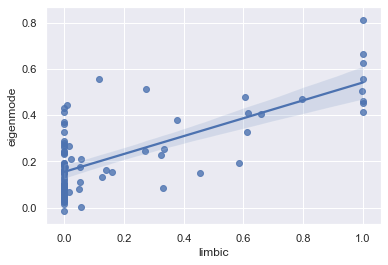

In [69]:
N = 10

# complex Laplacian eigenmodes:
brain.decompose_complex_laplacian(
    alpha=parameters.loc["Limbic", "alpha"],
    k=parameters.loc["Limbic", "wave_number"],
    vis=False,
)
print(brain.norm_eigenmodes.shape)

# compute the spatial correlations:
corrs = np.squeeze(np.zeros([len(brain.norm_eigenmodes), 1]))
for e in np.arange(0, len(corrs)):
    corrs[e] = pearsonr(np.squeeze(limbic_network), brain.norm_eigenmodes[:, e])[0]

# sort the eigenmodes:
ordered_eigenmodes = np.argsort(-np.round(corrs, 3))

# 
selected_eigs = brain.norm_eigenmodes[:, ordered_eigenmodes[0 : N]]
coef, res, _, _ = np.linalg.lstsq(selected_eigs, limbic_network, rcond=None)
comb = selected_eigs @ coef # dot product

df_limbic = pd.DataFrame(np.concatenate((limbic_network[:, np.newaxis], comb[:, np.newaxis]), axis = 1), columns = ['limbic', 'eigenmode'])
markers = {""}
axis_limbic = sns.regplot(data=df_limbic, x="limbic", y="eigenmode")

#### Default Network:

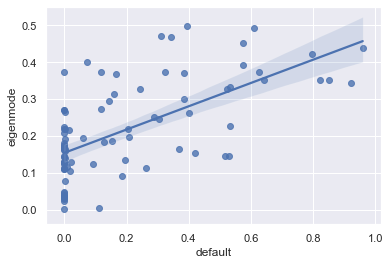

In [70]:
default_network = np.nan_to_num(fc_dk_normalized.loc["Default"].values)

# complex Laplacian eigenmodes:
brain.decompose_complex_laplacian(
    alpha=parameters.loc["Default", "alpha"],
    k=parameters.loc["Default", "wave_number"],
    vis=False,
)

# compute the spatial correlations:
corrs = np.squeeze(np.zeros([len(brain.norm_eigenmodes), 1]))
for e in np.arange(0, len(corrs)):
    corrs[e] = pearsonr(np.squeeze(default_network), brain.norm_eigenmodes[:, e])[0]

# sort the eigenmodes:
ordered_eigenmodes = np.argsort(-np.round(corrs, 3))

# 
selected_eigs = brain.norm_eigenmodes[:, ordered_eigenmodes[0 : N]]
coef, res, _, _ = np.linalg.lstsq(selected_eigs, default_network, rcond=None)
comb = selected_eigs @ coef # dot product

df_default = pd.DataFrame(np.concatenate((default_network[:, np.newaxis], comb[:, np.newaxis]), axis = 1), columns = ['default', 'eigenmode'])
markers = {""}
axis_default = sns.regplot(data=df_default, x="default", y="eigenmode")

#### Visual Network:

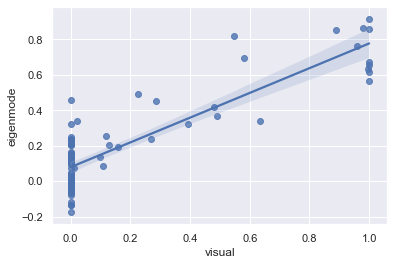

In [71]:
visual_network = np.nan_to_num(fc_dk_normalized.loc["Visual"].values)

# complex Laplacian eigenmodes:
brain.decompose_complex_laplacian(
    alpha=parameters.loc["Visual", "alpha"],
    k=parameters.loc["Visual", "wave_number"],
    vis=False,
)

# compute the spatial correlations:
corrs = np.squeeze(np.zeros([len(brain.norm_eigenmodes), 1]))
for e in np.arange(0, len(corrs)):
    corrs[e] = pearsonr(np.squeeze(visual_network), brain.norm_eigenmodes[:, e])[0]

# sort the eigenmodes:
ordered_eigenmodes = np.argsort(-np.round(corrs, 3))

# 
selected_eigs = brain.norm_eigenmodes[:, ordered_eigenmodes[0 : N]]
coef, res, _, _ = np.linalg.lstsq(selected_eigs, visual_network, rcond=None)
comb = selected_eigs @ coef # dot product

df_visual = pd.DataFrame(np.concatenate((visual_network[:, np.newaxis], comb[:, np.newaxis]), axis = 1), columns = ['visual', 'eigenmode'])
markers = {""}
axis_visual = sns.regplot(data=df_visual, x="visual", y="eigenmode")

#### Frontoparietal network:

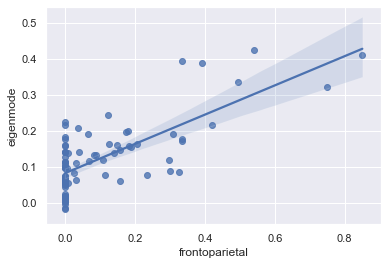

In [72]:
fronto_network = np.nan_to_num(fc_dk_normalized.loc["Frontoparietal"].values)

# complex Laplacian eigenmodes:
brain.decompose_complex_laplacian(
    alpha=parameters.loc["Frontoparietal", "alpha"],
    k=parameters.loc["Frontoparietal", "wave_number"],
    vis=False,
)

# compute the spatial correlations:
corrs = np.squeeze(np.zeros([len(brain.norm_eigenmodes), 1]))
for e in np.arange(0, len(corrs)):
    corrs[e] = pearsonr(np.squeeze(fronto_network), brain.norm_eigenmodes[:, e])[0]

# sort the eigenmodes:
ordered_eigenmodes = np.argsort(-np.round(corrs, 3))

# 
selected_eigs = brain.norm_eigenmodes[:, ordered_eigenmodes[0 : N]]
coef, res, _, _ = np.linalg.lstsq(selected_eigs, fronto_network, rcond=None)
comb = selected_eigs @ coef # dot product

df_fronto = pd.DataFrame(np.concatenate((fronto_network[:, np.newaxis], comb[:, np.newaxis]), axis = 1), columns = ['frontoparietal', 'eigenmode'])
markers = {""}
axis_fronto = sns.regplot(data=df_fronto, x="frontoparietal", y="eigenmode")

#### Somatomotor Network: 

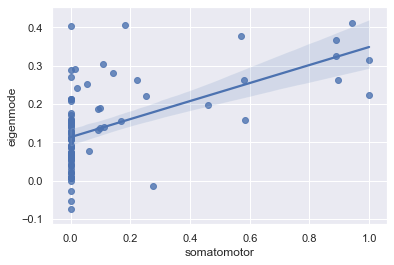

In [73]:
motor_network = np.nan_to_num(fc_dk_normalized.loc["Somatomotor"].values)

# complex Laplacian eigenmodes:
brain.decompose_complex_laplacian(
    alpha=parameters.loc["Somatomotor", "alpha"],
    k=parameters.loc["Somatomotor", "wave_number"],
    vis=False,
)

# compute the spatial correlations:
corrs = np.squeeze(np.zeros([len(brain.norm_eigenmodes), 1]))
for e in np.arange(0, len(corrs)):
    corrs[e] = pearsonr(np.squeeze(motor_network), brain.norm_eigenmodes[:, e])[0]

# sort the eigenmodes:
ordered_eigenmodes = np.argsort(-np.round(corrs, 3))

# 
selected_eigs = brain.norm_eigenmodes[:, ordered_eigenmodes[0 : N]]
coef, res, _, _ = np.linalg.lstsq(selected_eigs, motor_network, rcond=None)
comb = selected_eigs @ coef # dot product

df_motor = pd.DataFrame(np.concatenate((motor_network[:, np.newaxis], comb[:, np.newaxis]), axis = 1), columns = ['somatomotor', 'eigenmode'])
markers = {""}
axis_motor = sns.regplot(data=df_motor, x="somatomotor", y="eigenmode")

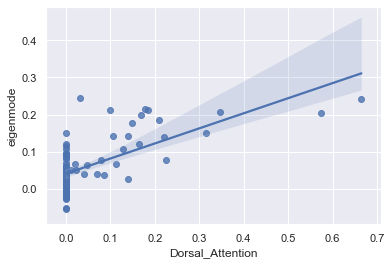

In [74]:
dorsal_network = np.nan_to_num(fc_dk_normalized.loc["Dorsal_Attention"].values)

# complex Laplacian eigenmodes:
brain.decompose_complex_laplacian(
    alpha=parameters.loc["Dorsal_Attention", "alpha"],
    k=parameters.loc["Dorsal_Attention", "wave_number"],
    vis=False,
)

# compute the spatial correlations:
corrs = np.squeeze(np.zeros([len(brain.norm_eigenmodes), 1]))
for e in np.arange(0, len(corrs)):
    corrs[e] = pearsonr(np.squeeze(dorsal_network), brain.norm_eigenmodes[:, e])[0]

# sort the eigenmodes:
ordered_eigenmodes = np.argsort(-np.round(corrs, 3))

# 
selected_eigs = brain.norm_eigenmodes[:, ordered_eigenmodes[0 : N]]
coef, res, _, _ = np.linalg.lstsq(selected_eigs, dorsal_network, rcond=None)
comb = selected_eigs @ coef # dot product

df_dorsal = pd.DataFrame(np.concatenate((dorsal_network[:, np.newaxis], comb[:, np.newaxis]), axis = 1), columns = ['Dorsal_Attention', 'eigenmode'])
markers = {""}
axis_dorsal = sns.regplot(data=df_dorsal, x="Dorsal_Attention", y="eigenmode")

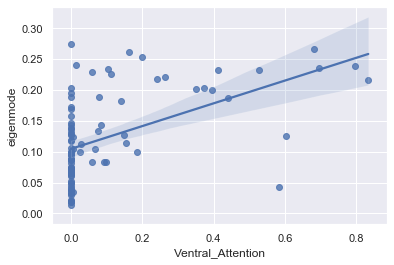

In [75]:
ventral_network = np.nan_to_num(fc_dk_normalized.loc["Ventral_Attention"].values)

# complex Laplacian eigenmodes:
brain.decompose_complex_laplacian(
    alpha=parameters.loc["Ventral_Attention", "alpha"],
    k=parameters.loc["Ventral_Attention", "wave_number"],
    vis=False,
)

# compute the spatial correlations:
corrs = np.squeeze(np.zeros([len(brain.norm_eigenmodes), 1]))
for e in np.arange(0, len(corrs)):
    corrs[e] = pearsonr(np.squeeze(ventral_network), brain.norm_eigenmodes[:, e])[0]

# sort the eigenmodes:
ordered_eigenmodes = np.argsort(-np.round(corrs, 3))

# 
selected_eigs = brain.norm_eigenmodes[:, ordered_eigenmodes[0 : N]]
coef, res, _, _ = np.linalg.lstsq(selected_eigs, ventral_network, rcond=None)
comb = selected_eigs @ coef # dot product

df_ventral = pd.DataFrame(np.concatenate((ventral_network[:, np.newaxis], comb[:, np.newaxis]), axis = 1), columns = ['Ventral_Attention', 'eigenmode'])
markers = {""}
axis_ventral = sns.regplot(data=df_ventral, x="Ventral_Attention", y="eigenmode")

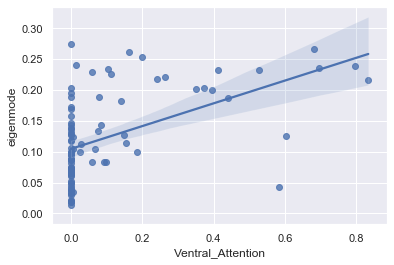

In [77]:
axis_ventral.get_figure()

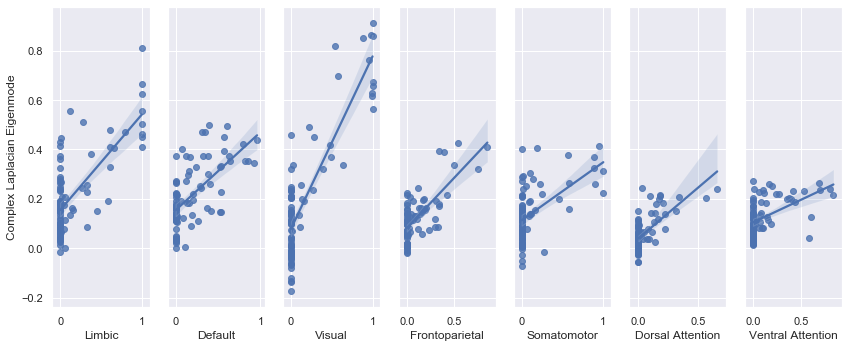

In [104]:
import matplotlib.pyplot as plt

fig,ax = plt.subplots(1, 7, figsize=(12,5), sharey=True)
sns.regplot(ax=ax[0], data=df_limbic, x="limbic", y="eigenmode")
ax[0].set(xlabel='Limbic', ylabel = 'Complex Laplacian Eigenmode')
sns.regplot(ax=ax[1], data=df_default, x="default", y="eigenmode")
ax[1].set(xlabel='Default', ylabel = '')
sns.regplot(ax=ax[2], data=df_visual, x="visual", y="eigenmode")
ax[2].set(xlabel='Visual', ylabel = '')
sns.regplot(ax=ax[3], data=df_fronto, x="frontoparietal", y="eigenmode")
ax[3].set(xlabel='Frontoparietal', ylabel = '')
sns.regplot(ax=ax[4], data=df_motor, x="somatomotor", y="eigenmode")
ax[4].set(xlabel='Somatomotor', ylabel = '')
sns.regplot(ax=ax[5], data=df_dorsal, x="Dorsal_Attention", y="eigenmode")
ax[5].set(xlabel='Dorsal Attention', ylabel = '')
sns.regplot(ax=ax[6], data=df_ventral, x="Ventral_Attention", y="eigenmode")
ax[6].set(xlabel='Ventral Attention', ylabel = '')

plt.tight_layout()
plt.savefig("../figures/supp/scatter_plot.png", dpi=300, bbox_inches="tight")

In [112]:
brain.decompose_complex_laplacian(alpha=parameters.loc["Ventral_Attention", "alpha"],
    k=parameters.loc["Ventral_Attention", "wave_number"],
    vis=False)
brain.eigenvalues

array([ 0.48478859+0.09408856j,  0.53663844-0.15156068j,
       -0.08928225+0.57697213j,  0.54344072+0.28441015j,
        0.69823713-0.08826569j,  0.71986779+0.10327179j,
        0.73241077-0.07271423j, -0.16087921+0.73842273j,
        0.61327048+0.45932417j,  0.69411177+0.38980866j,
        0.63402611+0.51830068j,  0.72227629-0.39439141j,
        0.83910353+0.13967676j,  0.8556285 -0.06374849j,
        0.72240552-0.53240168j,  0.4646731 +0.76774762j,
        0.89762393+0.10778283j,  0.8933646 -0.14542679j,
        0.50298803+0.76642969j,  0.92745115-0.18424164j,
        0.90113439-0.34460409j,  0.83432069+0.49440095j,
        0.36838294+0.910302j  ,  0.94142322-0.29652479j,
        0.84405809-0.53230445j,  0.99129118+0.18665465j,
        1.01546411-0.11966316j,  1.02865512-0.06244291j,
        0.92426252-0.47250292j,  1.0265855 -0.21171472j,
        1.06024398+0.01140921j,  0.98972727+0.43160732j,
        0.95357661-0.53994383j,  1.01432026-0.46191974j,
        1.11829725-0.21790101j,

In [108]:
brain.decompose_regular_laplacian()

In [109]:
brain.eigenvalues

array([-1.11022302e-16,  1.69690111e-01,  3.45213166e-01,  4.43881266e-01,
        4.53969509e-01,  4.83729942e-01,  5.25798447e-01,  5.31345502e-01,
        5.95570994e-01,  6.15878152e-01,  6.44864538e-01,  6.55359574e-01,
        6.94047246e-01,  7.24173194e-01,  7.44064534e-01,  7.75556419e-01,
        7.78977941e-01,  8.13912442e-01,  8.54041741e-01,  8.55977151e-01,
        8.69277722e-01,  8.80492872e-01,  9.14372804e-01,  9.21757264e-01,
        9.24331723e-01,  9.46119707e-01,  9.47918494e-01,  9.66595612e-01,
        9.69099703e-01,  9.94566982e-01,  9.96496969e-01,  1.00944105e+00,
        1.01128349e+00,  1.02088271e+00,  1.02423043e+00,  1.02921627e+00,
        1.04533019e+00,  1.04549861e+00,  1.06357371e+00,  1.06574211e+00,
        1.07368564e+00,  1.07775509e+00,  1.08201082e+00,  1.08483736e+00,
        1.09432410e+00,  1.09744882e+00,  1.10440641e+00,  1.10639893e+00,
        1.10871411e+00,  1.11352770e+00,  1.11660297e+00,  1.12544866e+00,
        1.12605445e+00,  